<a href="https://colab.research.google.com/github/katrinag2004/APIproject/blob/main/SCRIPTS/1_Preprocess_and_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import images from zip file

In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload your `data.zip`

In [ ]:
import zipfile
import os

# Unzip the file
with zipfile.ZipFile("snake_data.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

# Verify structure
for root, dirs, files in os.walk(".", topdown=True):
    print(root)

.
./.config
./.config/logs
./.config/logs/2025.04.07
./.config/configurations
./snake_data
./snake_data/snake_data
./snake_data/snake_data/test
./snake_data/snake_data/test/venemous
./snake_data/snake_data/test/non_venemous
./snake_data/snake_data/train
./snake_data/snake_data/train/venemous
./snake_data/snake_data/train/non_venemous
./__MACOSX
./__MACOSX/snake_data
./__MACOSX/snake_data/snake_data
./__MACOSX/snake_data/snake_data/test
./__MACOSX/snake_data/snake_data/test/venemous
./__MACOSX/snake_data/snake_data/test/non_venemous
./__MACOSX/snake_data/snake_data/train
./__MACOSX/snake_data/snake_data/train/non_venemous
./sample_data


Process the images

In [ ]:
#use tensorflow to process

import tensorflow as tf

#standard image size
img_size = (128, 128)
batch_size = 32

#create the directories for training and testing data
train_dir = '/content/snake_data/snake_data/train'
test_dir = '/content/snake_data/snake_data/test'

#set directories for training and testing
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int',  # or 'categorical' if needed
    shuffle=True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int',
    shuffle=False  # Important: don't shuffle test set
)

Found 2938 files belonging to 2 classes.
Found 1232 files belonging to 2 classes.


In [ ]:
#create binary classification of data

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

#classify data based on folders within the directory (venomous and nonvenomous)
train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)

test_data = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

Found 2938 images belonging to 2 classes.
Found 1232 images belonging to 2 classes.


In [ ]:
#flatten the training images to get EDA of pixels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your dataset (same as before)
dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=1,  # Load one at a time for easier DataFrame work
    shuffle=False
)

# Preprocessing function for MobileNetV2, the CNN we will use later
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Collect a few examples
image_list = []
label_list = []

for image, label in dataset:  # using all images in training data
    preprocessed = preprocess_input(image).numpy().squeeze()
    image_list.append(preprocessed)
    label_list.append(label.numpy().squeeze())

# Convert to DataFrame of label and image tensors
df = pd.DataFrame({
    'image_tensor': image_list,
    'label': label_list
})

# Show basic info
print(df.head())

Found 2938 files belonging to 2 classes.
                                        image_tensor label
0  [[[-1.0, -0.92156863, -0.9843137], [-1.0, -0.9...     0
1  [[[-0.043735266, 0.56274223, -0.3441555], [-0....     0
2  [[[-0.8752298, -0.9066023, -0.8987592], [-0.86...     0
3  [[[-0.78039217, -0.8666667, -0.8980392], [-0.7...     0
4  [[[0.017611623, 0.1195724, 0.18532872], [0.057...     0


In [ ]:
df.to_csv('flattened_images.csv', index=False)

#saving the csv of just the flattened training images

Create EDA plots: help from https://medium.com/geekculture/eda-for-image-classification-dcada9f2567a

In [ ]:
#read in the csv, or comment this out if df is already loaded
df = pd.read_csv('/content/flattened_images.csv')
print(df.shape)
print(df.columns)
print(df['label'].value_counts())  # Class distribution

#where 0 is nonvenomous and 1 is venomous

(2938, 3)
Index(['image_tensor', 'label', 'image_flattened'], dtype='object')
label
0    1581
1    1357
Name: count, dtype: int64


In [ ]:
class_names = train_ds.class_names
#get the names of the classes of the data from the directory (venomous and nonvenomous)

Text(0.5, 1.0, 'Class Distribution')

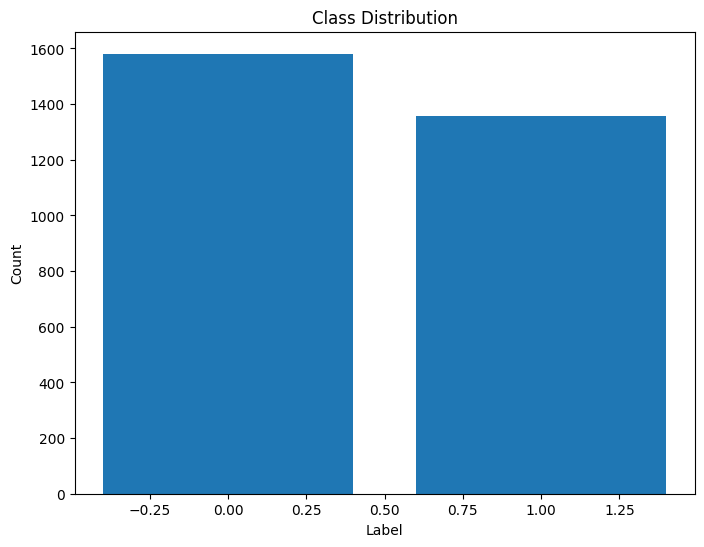

In [ ]:
#make bar plot of image distribution across classes

label_counts = df['label'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Class Distribution')

In [ ]:
from PIL import Image

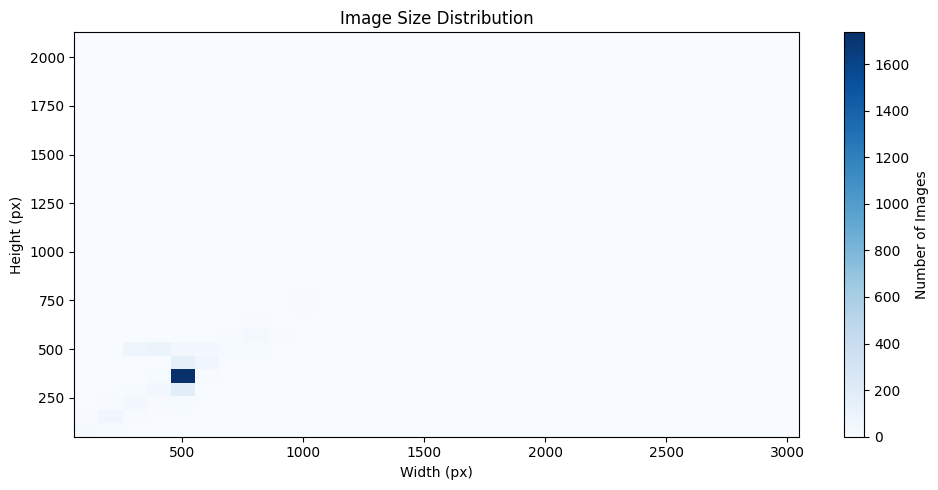

In [ ]:
#create a graph of the image size distribution

widths, heights = [], []

#cycle through images in the training directory and get their size
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                with Image.open(img_path) as img:
                    w, h = img.size
                    widths.append(w)
                    heights.append(h)
            except:
                continue  # skip unreadable/corrupt images


#create the figure to show width and height of images
plt.figure(figsize=(10, 5))
plt.hist2d(widths, heights, bins=(30, 30), cmap='Blues')
plt.colorbar(label='Number of Images')
plt.xlabel('Width (px)')
plt.ylabel('Height (px)')
plt.title('Image Size Distribution')
plt.tight_layout()
plt.show()

#concentrated in one area, so images are overall a similar shape - this is great for training our data

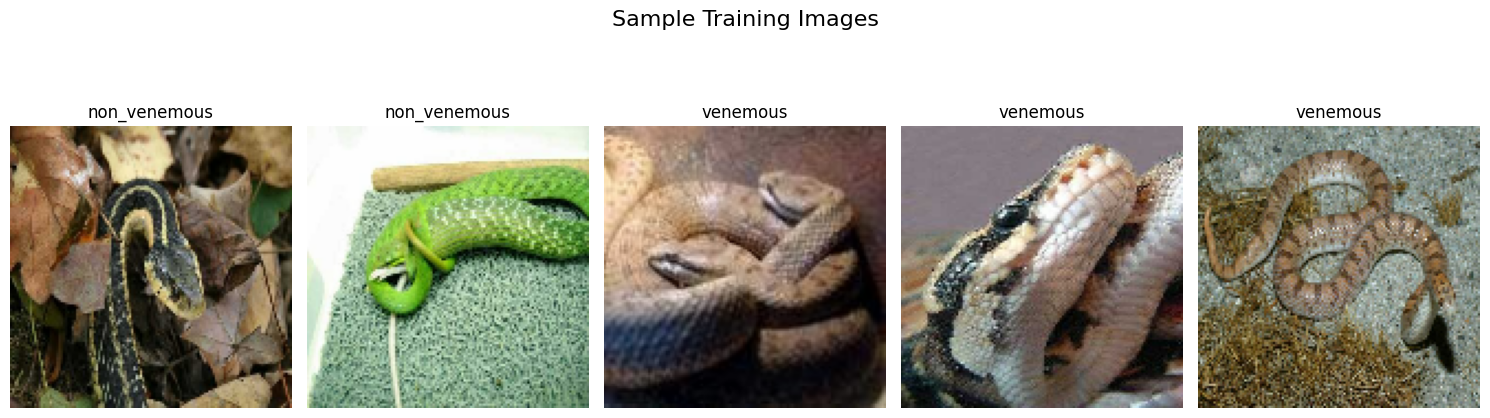

In [ ]:
#show a sample of images within the training data set along with their labels
#checking image quality and classifications


def show_sample_images(dataset, class_names, n=5):
    plt.figure(figsize=(15, 5))
    for images, labels in dataset.take(1):  # take 1 batch
        for i in range(n):
            ax = plt.subplot(1, n, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
    plt.suptitle("Sample Training Images", fontsize=16)
    plt.tight_layout()
    plt.show()

show_sample_images(train_ds, train_ds.class_names, n=5)